# Single weight behavior

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pystan
import scipy.stats as stats
import seaborn as sns
import tqdm
import sys
import ctypes
from IPython.display import display, clear_output, HTML
from numpy import trapz

sys.path.append('../')
from src.vimlts import VIMLTS

print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Tensorflow version: ',tf.__version__, )

tfd=tfp.distributions


def Mbox(title, text, style):
    return ctypes.windll.user32.MessageBoxW(0, text, title, style)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Tensorflow version:  2.4.1


## Data generating process
Draw samples from a mixture distribution

$y \sim MixtureCauchy(\mu_{0},\sigma, \mu_{1},\sigma)$

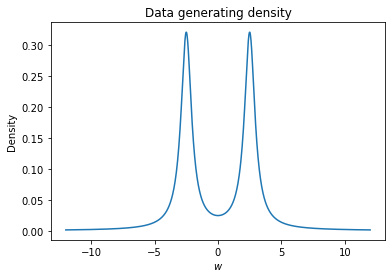

In [2]:
mu_0=2.5
mu_1=-2.5
sigma=sigma_0=sigma_1=0.5
mix=0.5

# Cauchy mixture distribution
a_bimix_cauchy = tfd.Mixture(
  cat=tfd.Categorical(probs=[mix, 1.-mix]),
  components=[
    tfd.Cauchy(loc=mu_0, scale=sigma_0),
    tfd.Cauchy(loc=mu_1, scale=sigma_1),
])

ww=np.linspace(-12.,12.,num=int(1e3))

plt.figure()
plt.plot(ww, a_bimix_cauchy.prob(ww)) 
plt.title(r'Data generating density')
plt.ylabel(r'Density')
plt.xlabel(r'$w$');

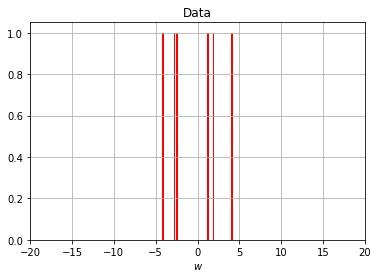

In [3]:
num = 6
tf.random.set_seed(0)
y = a_bimix_cauchy.sample(sample_shape=num)

y=np.array(y).reshape([-1])

plt.hist(y, color='r',bins=50)
plt.xlim([-20,20])
plt.grid()
plt.title(r'Data')
plt.xlabel(r'$w$');

## Ground truth

In [4]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel(r'samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.9)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.9)
    plt.title(r'Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30,zorder=1, density=True); sns.kdeplot(param,color='g',zorder=2, shade=True, label=r'kde')
    plt.xlabel(param_name)
    plt.ylabel(r'density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label=r'mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label=r'median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.9, label=r'95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.9)

    plt.gcf().tight_layout()
    plt.legend()

In [5]:
stan_code = """
data{
  int<lower=0> N;
  real<lower=0> sigma;
  vector[N] y;
}
parameters{
  real w; 
}
model{
  y ~ cauchy(w, sigma);
  w ~ normal(0, 1);
}
"""

mcmc_model=pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b95aa4ee4a5c99ef18a70ee9847fc747 NOW.


In [6]:
mcmc_data = {'N': num,
        'sigma': sigma,
        'y': y}
mcmc_fit=mcmc_model.sampling(data=mcmc_data,iter=8000,chains=8)

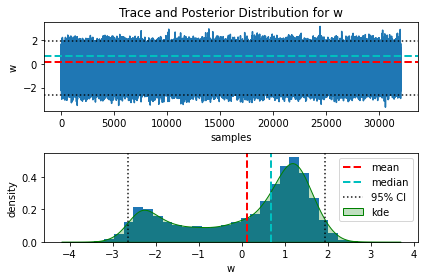

In [7]:
plt.figure()
plot_trace(mcmc_fit.extract()['w'],"w")

In [8]:
print(mcmc_fit.stansummary())

Inference for Stan model: anon_model_b95aa4ee4a5c99ef18a70ee9847fc747.
8 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=32000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w      0.12    0.04   1.44  -2.65  -1.12   0.69   1.25   1.93   1624   1.01
lp__ -19.28    0.01   0.72 -20.48 -19.81  -19.3 -18.61  -18.4   4498    1.0

Samples were drawn using NUTS at Fri May 21 09:57:09 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## MFVI

### Functions

In [9]:
# Convenience function to write out weights
class Logger:
    """
        Writes out the weights, gradient, and losses.
    """  
    def __init__(self, steps, num_weights = 4):
        self.steps = steps
        self.num_weights = num_weights
        self.X = np.zeros((steps,(4+2*num_weights)))
        
    def log(self, step, epoch, lambda_tunable, lambda_tunable_grad, loss, loss_kl, loss_nll):
        n = self.num_weights
        self.X[step,0] = epoch
        self.X[step,1:(n+1)] = lambda_tunable.numpy()
        self.X[step,(n+1):((2*n)+1)] = lambda_tunable_grad.numpy()
        self.X[step,((2*n)+1)] = loss.numpy()
        self.X[step,((2*n)+2)] = loss_kl.numpy()
        self.X[step,((2*n)+3)] = loss_nll.numpy()
        
    def getX(self):
        return self.X

In [10]:
def kl_divergence(q, p):
    """
        Calculates the kl divergence.
    """
    # Avoid numerical problems
    mask = ((q > 1e-08) | (p > 1e-08)) & (np.isinf(q)==0) & (np.isinf(p)==0)
    return tf.math.reduce_sum(tf.where(mask, tf.math.log(q/p), 0))

In [11]:
def get_lr(current_epoch):
    """
        Returns the learning rate depending to the current epoch.
    """
    lr_dyn=(epochs-current_epoch)/epochs
    return lr_start*lr_dyn+lr_end*(1-lr_dyn)

### Create a model

In [12]:
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import norm
tfd=tfp.distributions
log=tf.math.log

In [16]:
# Number of epochs
epochs=200

# Number of samples psi to approximate the expected value
num_samples=10

# Learning rate
lr_start=0.08
lr_end=0.03

# Variational parameters init
a_init=(0.2,)
b_init=(0.,)
alpha_init = (1,)
beta_init = (0,)

# ans=Mbox('Initialization', 'Using a high slope for the Bernstein polynomial initialization?', 4)
ans=6
if(ans==6):
    # Using a high slope will help to find a mode that creates a bimodal fit
    delta_theta_high_slope_init = (-6,2.,-6.,-6.,-6.,8.,-6.,-6.,-6,3.)
    delta_theta_init=delta_theta_high_slope_init
else:
    delta_theta_gaussian_like_init = (-5,1.,0.8,0.8,0.6,0.4,0.2,0.2,1.,1.5)
    delta_theta_init=delta_theta_gaussian_like_init

# delta_theta_init = [initializers.RandomNormal(mean=-1.5, stddev=.3)] + [initializers.RandomNormal(mean=softplus_inv((2+1.5)/(M-1)), stddev=.5) for i in range(M-1)])

lambda_init=a_init+b_init+delta_theta_init+alpha_init+beta_init
num_lambda=np.shape(lambda_init)[0]
lambda_tunable = tf.Variable(lambda_init,dtype='float32') 

# Instance of a variational distribution as VIMLTS
q_dist=VIMLTS(np.shape(delta_theta_init)[0])

# List to save the variational distribution during training
q_history=[]

# Prior
prior_dist=tfd.Normal(loc=0.,scale=1.)

# Logging
logger = Logger(epochs,num_weights=num_lambda)

ytensor = y.reshape([len(y),1])

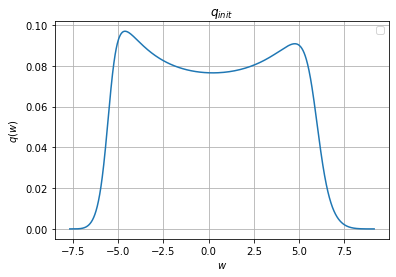

In [17]:
# Update the variational parameter to the variational distribution
q_dist.update_lambda_param(lambda_tunable)

# Save the distribution to the history
q_history.append(q_dist.get_target_dist())

plt.plot(q_history[0][1],q_history[0][0])
plt.legend()
plt.grid()
plt.title(r'$q_{init}$')
plt.ylabel(r'$q(w)$')
plt.xlabel(r'$w$');

In [16]:
for i in tqdm.tqdm(range(epochs)):
    with tf.GradientTape() as tape:  
        tape.watch([lambda_tunable])

        # Parameter update --------------------------------------------------
        q_dist.update_lambda_param(lambda_tunable)

        # Iterarte over psi (number of samples)
        for current_sample in range(num_samples):
            # l_nll ------------------------------------------
            z_sample,w_sample=q_dist.get_sample_w()

            # Likelihood
            y_prob = tfd.Cauchy(loc=w_sample, scale=sigma)
            # loss_nll
            l_nll_sample=-tf.reduce_sum(y_prob.log_prob(ytensor))
            l_nll_sample=tf.reshape(l_nll_sample,[-1])
            if current_sample==0:
                l_nll_list = l_nll_sample
            else:
                l_nll_list= tf.concat([l_nll_list,tf.reshape(l_nll_sample,[-1])],axis=0)


        # l_kl ------------------------------------------     
            variational_dist_sample,w=q_dist.get_target_dist_for_z(z_sample)
            prior_sample=prior_dist.prob(w_sample)
            l_kl_sample=kl_divergence(variational_dist_sample,prior_sample)
            l_kl_sample=tf.reshape(l_kl_sample,[-1])
            if current_sample==0:
                l_kl_list = l_kl_sample
            else:
                l_kl_list= tf.concat([l_kl_list,l_kl_sample],axis=0)


        l_nll=tf.reduce_mean(l_nll_list,axis=0)
        l_kl=tf.reduce_mean(l_kl_list,axis=0)

        # loss --------------------------------------
        loss = l_nll + l_kl

    grads = tape.gradient(loss,lambda_tunable)
    
    # Check for NaNs in gradient
    if True in tf.math.is_nan(grads):
        print("+++++++++NaN in gradient+++++++++++++")
        print("Parameter:", w_sample.numpy())
        print("Grads:",grads)
        continue
        
    # Save epoche to logger
    logger.log(i, i, lambda_tunable, grads, loss, l_kl, l_nll)    

    # Update the variational parameter
    lr=get_lr(i)
    lambda_tunable = tf.Variable(lambda_tunable - lr*grads)
    

    # Prints and history
    if i % 10 == 0 or i < 10 or i==epochs-1:
        clear_output()
        print("\tloss \t", loss.numpy(),"\tl_nll\t",l_nll.numpy(),"\tl_kl\t",l_kl.numpy(), "\tlr ", lr)
        save_history=True
        if(save_history):
            q_history.append(q_dist.get_target_dist())

100%|██████████| 200/200 [00:56<00:00,  3.52it/s]	loss 	 21.044989 	l_nll	 20.556803 	l_kl	 0.48818603 	lr  0.03025



### Analyse the run

#### Compare the VIMLTS solution to the ground truth

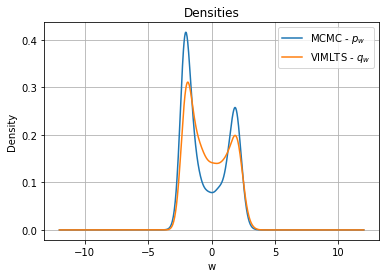

In [17]:
# Check density with sampling to avoid the usage of the none-existing inverse
sample_list=[]
for i in range(5000):
    z_sample,w_sample=q_dist.get_sample_w()
    sample_list.append(w_sample.numpy()[0])

# Calc the KDE
w_MCMC_density_kde = stats.gaussian_kde(mcmc_fit.extract()['w']);
w_VIMLTS_density_kde = stats.gaussian_kde(sample_list);


# Calculate the local max
local_max = (np.diff(np.sign(np.diff(w_VIMLTS_density_kde(ww)))) < 0).nonzero()[0] + 1

# Plot the run
plt.plot(ww,w_MCMC_density_kde(ww),label=r"MCMC - $p_{w}$");
plt.plot(ww,w_VIMLTS_density_kde(ww),label=r"VIMLTS - $q_{w}$");
plt.grid()
plt.legend();
plt.title(r'Densities')
plt.ylabel(r'Density')
plt.xlabel(r'w');

#### Calculate the location and the number of maxima

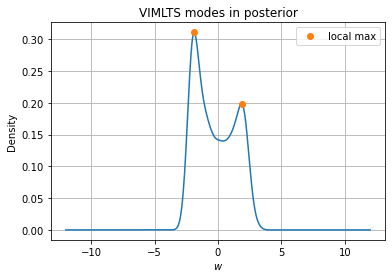

In [18]:
local_max = (np.diff(np.sign(np.diff(w_VIMLTS_density_kde(ww)))) < 0).nonzero()[0] + 1 # local max

plt.plot(ww,w_VIMLTS_density_kde(ww))
plt.plot(ww[local_max], w_VIMLTS_density_kde(ww)[local_max], "o", label="local max")
plt.legend()
plt.grid()
plt.title(r'VIMLTS modes in posterior')
plt.ylabel(r'Density')
plt.xlabel(r'$w$');

#### Analyse the loss

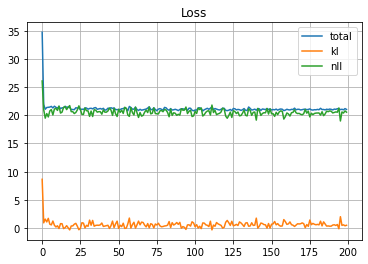

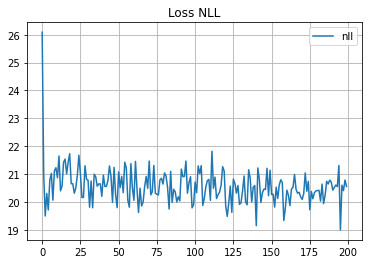

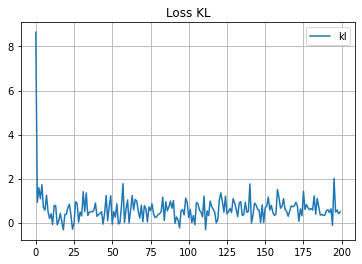

nll:	 20.55680274963379
kl:	 0.4022531509399414
total:	 21.04498863220215


In [19]:
W = logger.getX()
loss_history = W[:,W.shape[1]-3]
loss_history_nll = W[:,W.shape[1]-1]
loss_history_kl = W[:,W.shape[1]-2]

plt.plot(loss_history,label=r"total")
plt.plot(loss_history_kl,label=r"kl")
plt.plot(loss_history_nll,label=r"nll")
plt.legend()
plt.grid()
plt.title(r"Loss")
plt.show()

plt.figure()
plt.plot(loss_history_nll,label=r"nll")
plt.legend()
plt.grid()
plt.title(r"Loss NLL")
plt.show()


plt.figure()
plt.plot(loss_history_kl,label=r"kl")
plt.legend()
plt.grid()
plt.title(r"Loss KL")
plt.show()

print("nll:\t",W[W.shape[0]-1,W.shape[1]-1])
print("kl:\t",W[W.shape[0]-2,W.shape[1]-2])
print("total:\t",W[W.shape[0]-1,W.shape[1]-3])

#### Show the density without the KDE using the inverse approximation

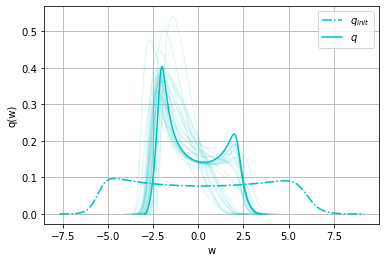

In [20]:
length_history=np.shape(q_history)[0]

plt.plot(q_history[0][1],q_history[0][0],'c-.',label=r"$q_{init}$")
for i in range(1,length_history-2):
    plt.plot(q_history[i][1],q_history[i][0],'c',alpha=0.1)
plt.plot(q_history[length_history-1][1],q_history[length_history-1][0],'c',label=r"$q$")

plt.legend()
plt.grid()
plt.ylabel(r"q(w)")
plt.xlabel(r"w");

#### Show history of the variational distribution. 

*Since there is an approximation in the change of variable formula, the densities are not correct!*

In [21]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def print_variational_q_dist(i):
    plt.plot(q_history[i][1],q_history[i][0],'c')
    plt.grid()
    return

In [22]:
interact(print_variational_q_dist, i=widgets.IntSlider(min=0, max=np.shape(q_history)[0]-2, step=1, value=10));

interactive(children=(IntSlider(value=10, description='i', max=29), Output()), _dom_classes=('widget-interact'…

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


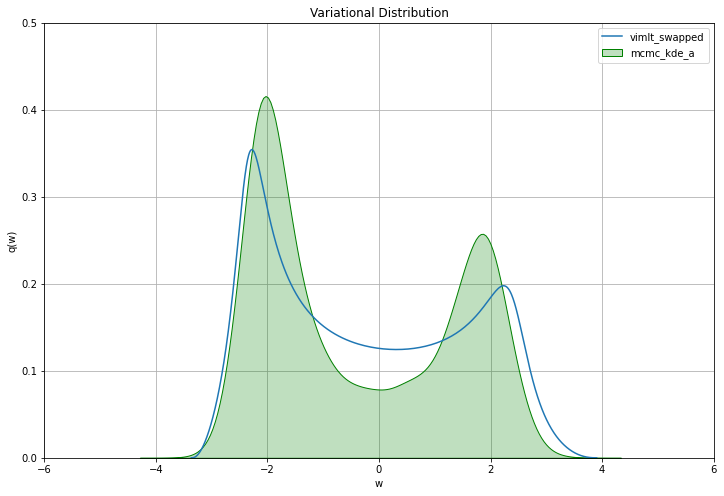

In [23]:
fig, ax = plt.subplots(figsize=(12,8));
fig.patch.set_facecolor('white');
sns.kdeplot(mcmc_fit.extract()['w'],color='g',zorder=2, shade=True, label="mcmc_kde_a")
xdata, ydata = [], []

ln, = ax.plot([], [])


x_min=-6
x_max=6
y_min=0
y_max=0.5


def init():
    ax.set_xlim(x_min, x_max);
    ax.set_ylim(y_min, y_max);
    return ln,

def animate(i):
    ln.set_ydata(q_history[i][0]); 
    ln.set_xdata(q_history[i][1]);
    ln.set_label("vimlt_swapped")
    plt.legend()
    return ln,


ani = animation.FuncAnimation(fig, animate, np.arange(0, np.shape(q_history)[0]-1), init_func=init,
    interval=100, blit=True);

plt.grid();
plt.title(r"Variational Distribution");
plt.xlabel(r"w");
plt.ylabel(r"q(w)");
plt.legend()

HTML(ani.to_jshtml());

# 